# 回帰問題にshap値を応用した場合

###　参考にしたページ
http://www.ie110704.net/2019/04/26/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8B%E6%8C%87%E6%A8%99shap%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6/

### 準備

In [29]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from sklearn import datasets, model_selection, metrics
import lightgbm as lgb
import shap
from IPython.core.display import display

In [30]:
# load JS visualization code to notebook
shap.initjs()

### データの読み込み

In [63]:
boston = datasets.load_boston()
df_boston = pd.DataFrame(data=np.c_[boston['data'], boston['target']], columns=boston['feature_names'].tolist() + ['target'])
display(df_boston.head())
display(df_boston.describe())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
train_X, valid_X, train_y, valid_y = model_selection.train_test_split(df_boston[boston['feature_names'].tolist()], df_boston[['target']], test_size=0.2, random_state=42)
print(train_X.shape, valid_X.shape, train_y.shape, valid_y.shape)

(404, 13) (102, 13) (404, 1) (102, 1)


### LightGBMを実装。モデルを作成

In [31]:
model = lgb.LGBMRegressor()
model.fit(train_X, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

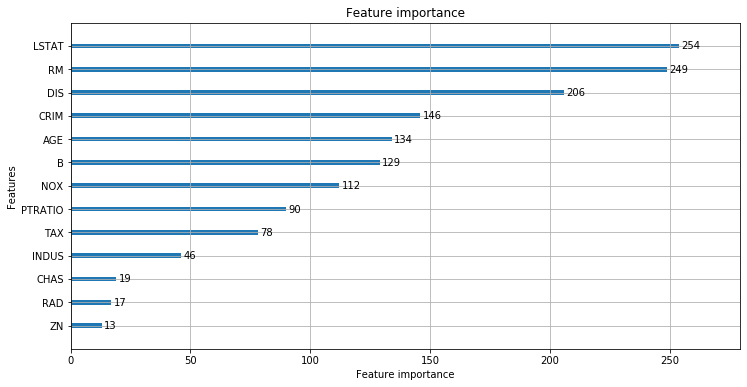

In [48]:
from matplotlib import pyplot as plt
%matplotlib inline

lgb.plot_importance(model, figsize=(12, 6))

In [49]:

print('MSE train: %.3f, valid: %.3f' % (
    metrics.mean_squared_error(train_y, model.predict(train_X)),
    metrics.mean_squared_error(valid_y, model.predict(valid_X))
))
print('R^2 train: %.3f, valid: %.3f' % (
    metrics.r2_score(train_y, model.predict(train_X)),
    metrics.r2_score(valid_y, model.predict(valid_X))
))


MSE train: 2.283, valid: 8.339
R^2 train: 0.974, valid: 0.886


### SHAPのモデルを作成

In [50]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_X)

### 1サンプルを予測させた時、どの特徴量がプラス・マイナスに効いたかを確認する
- 各特徴量の値とそれが予測に対して正の方向に働いたものを赤色、負の方向に働いたものを青色としてプロットされます。
- 例えばこのサンプル(train_Xの0行目)においては、LSTAT=24.91であり、この値は予測に対して負の方向に引っ張っていると見てとれます。

In [55]:
#shapのbase value
explainer.expected_value

22.796534689899794

In [56]:
#train_Xの0行目
train_X.iloc[0,:]

CRIM        15.0234
ZN           0.0000
INDUS       18.1000
CHAS         0.0000
NOX          0.6140
RM           5.3040
AGE         97.3000
DIS          2.1007
RAD         24.0000
TAX        666.0000
PTRATIO     20.2000
B          349.4800
LSTAT       24.9100
Name: 477, dtype: float64

In [83]:
shap_values[0,:]

array([-6.88053290e-01,  5.99116208e-03, -1.37495706e-01, -7.02427131e-02,
        5.58217093e-01, -3.35206937e+00, -6.58894610e-01,  7.83039498e-01,
        8.82776913e-02, -3.49710758e-01, -6.23724500e-01,  3.55817407e-02,
       -6.57023618e+00])

In [99]:
shap_values_df=pd.DataFrame(shap_values)
print(df_boston.columns[:13])
shap_values_df.columns = df_boston.columns[:13]

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


In [100]:
shap_values_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.688053,0.005991,-0.137496,-0.070243,0.558217,-3.352069,-0.658895,0.783039,0.088278,-0.349711,-0.623725,0.035582,-6.570236
1,0.749045,0.008963,-0.089145,-0.049595,-0.020185,-2.970571,0.249053,-0.326860,-0.055596,0.001883,-1.649716,0.221173,1.031157
2,-0.578984,-0.046775,-0.225360,-0.054854,0.094868,-3.058091,0.859783,-1.060040,-0.201580,-0.356225,0.469981,-0.402982,1.055197
3,-0.052572,0.007845,-0.127933,-0.053833,0.447625,-2.146905,-0.313299,-0.324438,0.109265,-0.453089,-0.563227,-0.928029,-5.346173
4,0.331208,0.013328,-0.207331,-0.049916,0.092835,-3.397524,0.166897,0.305672,-0.101728,-0.069585,-1.132416,0.014921,-0.494699


In [85]:
print(train_y.iloc[0,:])
display(shap.force_plot(explainer.expected_value, shap_values[0,:], train_X.iloc[0,:]))

target    12.0
Name: 477, dtype: float64


### 全サンプルの予測値がどの特徴量を見たかを確認する
- インタラクティブなグラフで出力されるので、特徴量の細かい部分についてはオンマウスで確認できます。
- 横軸にサンプルが並んでいて（404件）、縦軸に予測値が出力され、どの特徴量がプラス、マイナスに働いたかを確認できます。
- explainer.expected_valueを元に、プラスに効いたのかマイナスに効いたのかを判断する

In [86]:
shap.force_plot(explainer.expected_value, shap_values, train_X)

### 特徴量別に予測値はどう関係しているのか？
- ドットがデータで、横軸がSHAP値を表しており、色が特徴量の大小を表しています。
- 例えば、RMは高ければ予測値も高くなる傾向にあり、低ければ予測値も低くなる傾向があるようです。
- LSTATは逆のようで、高ければ予測値は低くなり、低ければ予測値は高くなる傾向にあるようです

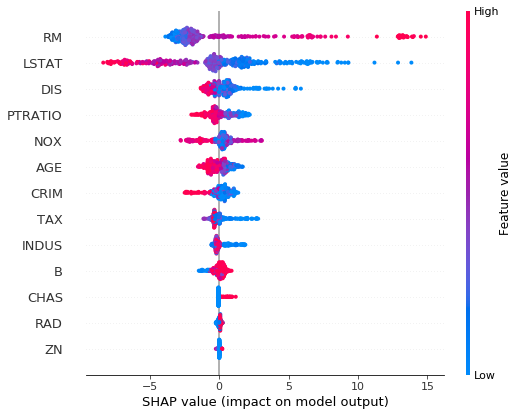

In [87]:
shap.summary_plot(shap_values, train_X)

### SHAPの絶対値で特徴量軸を比較してプロットでき、どの特徴量が予測に重要かが視覚化できる
- Shap値の平均が高い特徴量ほど、予測に重要と言えるらしい
- Lightgbmのfeature_importanceと比較しても順番はほぼほぼ一緒。

In [105]:
abs(shap_values_df.mean())

CRIM       0.145216
ZN         0.000920
INDUS      0.031302
CHAS       0.003309
NOX        0.111750
RM         0.348222
AGE        0.012556
DIS        0.298646
RAD        0.008047
TAX        0.015111
PTRATIO    0.106097
B          0.021846
LSTAT      0.367897
dtype: float64

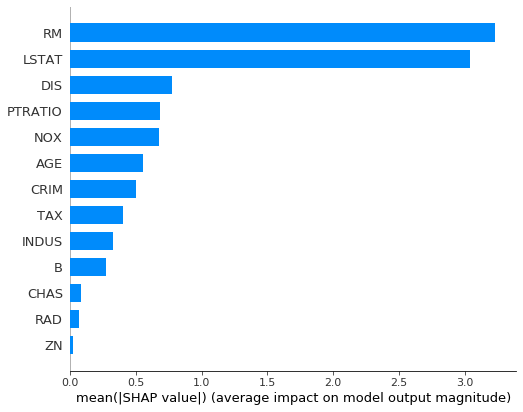

In [90]:
shap.summary_plot(shap_values, train_X, plot_type='bar')

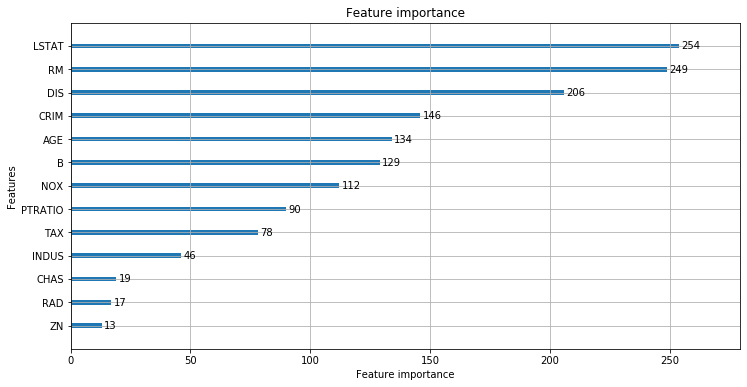

In [91]:
# 再掲：lightdbmのfeture_importance
lgb.plot_importance(model, figsize=(12, 6))

### 以下のようにして、ある特徴量軸だけに注目してグラフを出力も可能
- ドットがデータで、横軸が対象特徴量軸の値、縦軸が対象特徴量軸のSHAP値
- これを見ても、RMが高くなればなるほど、SHAP値も高くなる傾向にあり、予測値が上がることが分かる
- 実際に学習データのRMとtargetの相関係数も0.71
- 

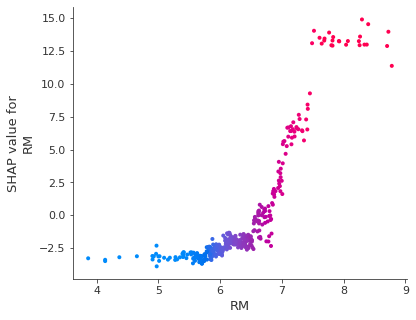

In [92]:
shap.dependence_plot('RM', shap_values, train_X, interaction_index='RM')